# Código final

In [5]:
# Instalar seaborn si no está instalado
def install_and_import(package):
    import importlib
    try:
        importlib.import_module(package)
    except ImportError:
        import sys
        import subprocess
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
    finally:
        globals()[package] = importlib.import_module(package)

install_and_import('seaborn')

In [1]:
# Importación de Librerías
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

In [2]:
# Configuración para visualizaciones
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Comprensión de los Datos

In [3]:
# Cargar datos
df = pd.read_csv('MXvideos_cc50_202101.csv')
category_df = pd.read_json('MX_category_id.json')

In [4]:
# Mapear IDs de categoría con nombres
# Convertir el JSON de categorías a un DataFrame
categories = {item['id']: item['snippet']['title'] for item in category_df['items']}
categories_df = pd.DataFrame(list(categories.items()), columns=['category_id', 'category_name'])

In [6]:
# Hacer merge entre el DataFrame principal y el DataFrame de categorías
# Convertir category_id a string para que coincida con el JSON
df['category_id'] = df['category_id'].astype(str).str.replace('.0', '', regex=False)
categories_df['category_id'] = categories_df['category_id'].astype(str)

# Realizar el merge
df = df.merge(categories_df, on='category_id', how='left')

# Verificar que el merge fue exitoso
print("Categorías mapeadas:")
print(df[['category_id', 'category_name']].drop_duplicates().sort_values('category_id'))

Categorías mapeadas:
     category_id         category_name
25             1      Film & Animation
5             10                 Music
189           15        Pets & Animals
18            17                Sports
285           19       Travel & Events
24             2      Autos & Vehicles
113           20                Gaming
1             22        People & Blogs
10            23                Comedy
0             24         Entertainment
2             25       News & Politics
4             26         Howto & Style
73            27             Education
107           28  Science & Technology
56            29                   NaN
1360          43                 Shows
176          nan                   NaN


In [8]:
# Limpiar datos con categorías NaN
print(f"Filas con category_name NaN antes de la limpieza: {df['category_name'].isna().sum()}")

# Filtrar filas con category_name válido
df_clean = df[df['category_name'].notna()].copy()

print(f"Filas después de la limpieza: {len(df_clean)}")
print(f"Filas con category_name NaN después de la limpieza: {df_clean['category_name'].isna().sum()}")

# Actualizar df para usarlo en el resto del análisis
df = df_clean

Filas con category_name NaN antes de la limpieza: 3844
Filas después de la limpieza: 40199
Filas con category_name NaN después de la limpieza: 0


In [6]:
# Vista preliminar de los datos
print("Primeras filas del dataset:\n")
df.head(20)

Primeras filas del dataset:



,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,state,lat,lon,geometry
0,SbOwzAl9ZfQ,17.14.11,Capítulo 12 | MasterChef 2017,MasterChef 2017,24.0,13/11/2017 1:06,"MasterChef Junior 2017|""TV Azteca""|""recetas""|""...",310130.0,4182.0,361.0,1836.0,https://i.ytimg.com/vi/SbOwzAl9ZfQ/default.jpg,FALSO,FALSO,FALSO,Disfruta la presencia del Chef Torreblanca en ...,Tlaxcala,19.319995,-98.230010,POINT (-98.2300096 19.31999514)
1,klOV6Xh-DnI,17.14.11,ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...,Micky Contreras Martinez,22.0,13/11/2017 0:11,La Voz Mexico 7,104972.0,271.0,174.0,369.0,https://i.ytimg.com/vi/klOV6Xh-DnI/default.jpg,FALSO,FALSO,FALSO,ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...,Michoacan,19.679973,-100.569996,POINT (-100.569996 19.67997316)
2,6L2ZF7Qzsbk,17.14.11,LOUIS CKAGÓ - EL PULSO DE LA REPÚBLICA,El Pulso De La República,25.0,13/11/2017 12:00,"Chumel Torres|""El Pulso de la Republica""|""noti...",136064.0,10105.0,266.0,607.0,https://i.ytimg.com/vi/6L2ZF7Qzsbk/default.jpg,FALSO,FALSO,FALSO,La canción del principio se llama “Este espíri...,Guerrero,17.549974,-99.500010,POINT (-99.5000096 17.54997398)
3,hcY52MFWMDM,17.14.11,Sismo de 6.7 sacude Costa Rica 12 Noviembre 2017,Casanare,25.0,12/11/2017 22:47,"temblor|""costa rica""|""sismo en costa rica""",96153.0,378.0,171.0,208.0,https://i.ytimg.com/vi/hcY52MFWMDM/default.jpg,FALSO,FALSO,FALSO,El video es de un Walmart en el pais centroame...,Hidalgo,20.170434,-98.730031,POINT (-98.73003076000001 20.17043418)
4,_OXDcGPVAa4,17.14.11,DOG HACKS | MUSAS LESSLIE LOS POLINESIOS,Musas,26.0,13/11/2017 14:17,"MUSAS|""lesslie""|""karen""|""hacks""|""perros""|""dogs...",499965.0,57781.0,681.0,7428.0,https://i.ytimg.com/vi/_OXDcGPVAa4/default.jpg,FALSO,FALSO,FALSO,MI HERMANO NARRA MI RUTINA DE MAQUILLAJE\nhttp...,Jalisco,19.770019,-104.369997,POINT (-104.3699966 19.77001935)
5,Q9kK6NWZR1U,17.14.11,Asi se sintio Terremoto en iraq al bordo de ir...,MÚSICA & ENTRETENIMIENTO,10.0,12/11/2017 15:17,[none],129645.0,506.0,67.0,239.0,https://i.ytimg.com/vi/Q9kK6NWZR1U/default.jpg,FALSO,FALSO,FALSO,Un fuerte sismo ha afectado en la noche de est...,Colima,18.920381,-103.879975,POINT (-103.8799748 18.92038129)
6,c9VTD3n_IDs,17.14.11,La Resolana con el Capi | Programa 12 noviembr...,La Resolana,22.0,13/11/2017 2:00,"la resolana|""la resolana con el capi""|""tv azte...",75197.0,2277.0,69.0,164.0,https://i.ytimg.com/vi/c9VTD3n_IDs/default.jpg,FALSO,FALSO,FALSO,Hoy en La Resolana vamos a divertirnos con nue...,Michoacan,19.679973,-100.569996,POINT (-100.569996 19.67997316)
7,XzULSsZYMRc,17.14.11,M6.7 Costa Rica Análisis de Terremotos en (((A...,concienciaradio,25.0,13/11/2017 1:18,"terremoto|""costa rica""|""nicaragua""|""alex backm...",142522.0,7745.0,659.0,0.0,https://i.ytimg.com/vi/XzULSsZYMRc/default.jpg,VERDADERO,FALSO,FALSO,"(CR NOTICIAS NOV 12, 2017) UN FUERTE TERREMOTO...",Puebla,18.900021,-98.449996,POINT (-98.44999618 18.90002077)
8,uijjYNtl_UM,17.14.11,7 Niños Famosos Que No Supieron Adaptarse a La...,Los mejores Top 10,24.0,12/11/2017 14:54,"los mejores top 10|""top 10 niños""|""top 10""|""to...",371110.0,20155.0,912.0,766.0,https://i.ytimg.com/vi/uijjYNtl_UM/default.jpg,FALSO,FALSO,FALSO,7 Niños Famosos Que No Supieron Adaptarse a La...,Puebla,18.900021,-98.449996,POINT (-98.44999618 18.90002077)
9,cOJ68MQm2ac,17.14.11,TOP: Los 7 libros infantiles más perturbadores...,DrossRotzank,24.0,12/11/2017 16:14,"libros infantiles|""Dross""|""terror""|""horror""|""m...",1111314.0,83582.0,2194.0,9106.0,https://i.ytimg.com/vi/cOJ68MQm2ac/default.jpg,FALSO,FALSO,FALSO,Actualizo 3 veces por semana. Si el video te g...,Chihuahua,26.933355,-105.666636,POINT (-105.6666358 26.93335472)


In [7]:
print("\nInformación del dataset:\n")
df.info()


Información del dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44043 entries, 0 to 44042
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   video_id                43959 non-null  object 
 1   trending_date           40593 non-null  object 
 2   title                   40510 non-null  object 
 3   channel_title           40501 non-null  object 
 4   category_id             40451 non-null  float64
 5   publish_time            40451 non-null  object 
 6   tags                    40480 non-null  object 
 7   views                   40451 non-null  float64
 8   likes                   40451 non-null  float64
 9   dislikes                40451 non-null  float64
 10  comment_count           40451 non-null  float64
 11  thumbnail_link          40471 non-null  object 
 12  comments_disabled       40451 non-null  object 
 13  ratings_disabled        40451 non-null  object 
 14  video_error

In [9]:
# identificar valores unicos en 'comments_disabled', 'ratings_disabled' y 'video_error_or_removed'

print("\nUnique values for 'comments_disabled':", df['comments_disabled'].unique())
print("Unique values for 'ratings_disabled':", df['ratings_disabled'].unique())
print("Unique values for 'video_error_or_removed':", df['video_error_or_removed'].unique())


Unique values for 'comments_disabled': ['FALSO' 'VERDADERO' nan]
Unique values for 'ratings_disabled': ['FALSO' 'VERDADERO' nan]
Unique values for 'video_error_or_removed': ['FALSO' 'VERDADERO' nan]


In [10]:
print("\nEstadísticas descriptivas:\n")
df.describe()


Estadísticas descriptivas:



,views,likes,dislikes,comment_count,lat,lon
count,1.106400e+04,1.106400e+04,1.106400e+04,11064.000000,12083.000000,12083.000000
mean,3.283558e+05,1.662136e+04,9.337720e+02,2382.482375,21.445662,-100.217535
std,2.060046e+06,8.675606e+04,1.963261e+04,17732.534077,3.501979,6.000914
min,1.570000e+02,0.000000e+00,0.000000e+00,0.000000,16.429991,-116.009260
25%,1.379500e+04,2.600000e+02,1.400000e+01,35.000000,18.920381,-103.500024
50%,4.958250e+04,1.122500e+03,5.400000e+01,175.000000,20.379982,-99.669999
75%,1.975178e+05,7.695000e+03,2.610000e+02,909.750000,22.733353,-98.230010
max,1.009124e+08,2.656698e+06,1.353667e+06,827784.000000,30.764051,-86.711455


In [ ]:
df.columns.values

array(['video_id', 'trending_date', 'title', 'channel_title',
       'category_id', 'publish_time', 'tags', 'views', 'likes',
       'dislikes', 'comment_count', 'thumbnail_link', 'comments_disabled',
       'ratings_disabled', 'video_error_or_removed', 'description',
       'state', 'lat', 'lon', 'geometry'], dtype=object)

In [11]:
print(df['state'].value_counts())

state
Tabasco                423
Queretaro              411
Morelos                408
Mexico                 402
Tlaxcala               401
Michoacan              395
Puebla                 391
Nayarit                391
Jalisco                390
Veracruz               388
Chiapas                387
Durango                384
Yucatan                382
Guanajuato             382
Campeche               381
Coahuila               377
Sonora                 376
Oaxaca                 374
Guerrero               374
Baja California        373
Zacatecas              366
Chihuahua              366
San Luis Potosi        365
Distrito Federal       365
Sinaloa                364
Nuevo Leon             364
Baja California Sur    364
Colima                 359
Tamaulipas             356
Quintana Roo           351
Aguascalientes         341
Hidalgo                332
Name: count, dtype: int64


In [ ]:
# Frecuencia por categoría
print(df['category_id'].value_counts())

category_id
24.0    13487
22.0     8159
17.0     4050
10.0     3371
25.0     3113
26.0     2467
23.0     1742
1.0      1298
20.0      994
27.0      532
28.0      531
2.0       252
29.0      252
19.0      117
15.0       83
43.0        3
Name: count, dtype: int64


In [ ]:
#Distribución de videos por categoría
sns.countplot(data=df, x='category_id')
plt.title('Distribución de videos por categoría')
plt.xlabel('Categoría')
plt.ylabel('Conteo')
plt.show()

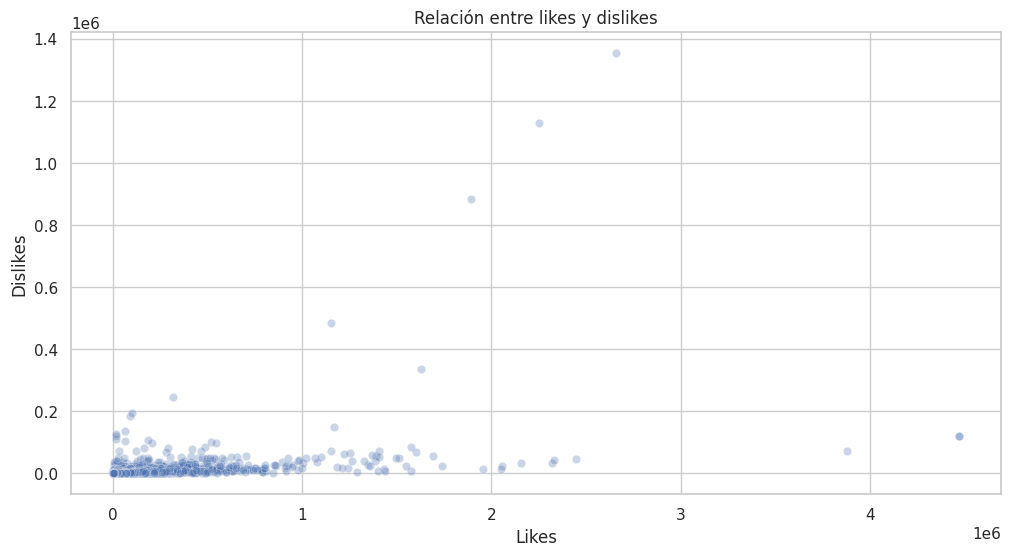

In [ ]:
#Relación entre likes y dislikes
sns.scatterplot(data=df, x='likes', y='dislikes', alpha=0.3)
plt.title('Relación entre likes y dislikes')
plt.xlabel('Likes')
plt.ylabel('Dislikes')
plt.show()

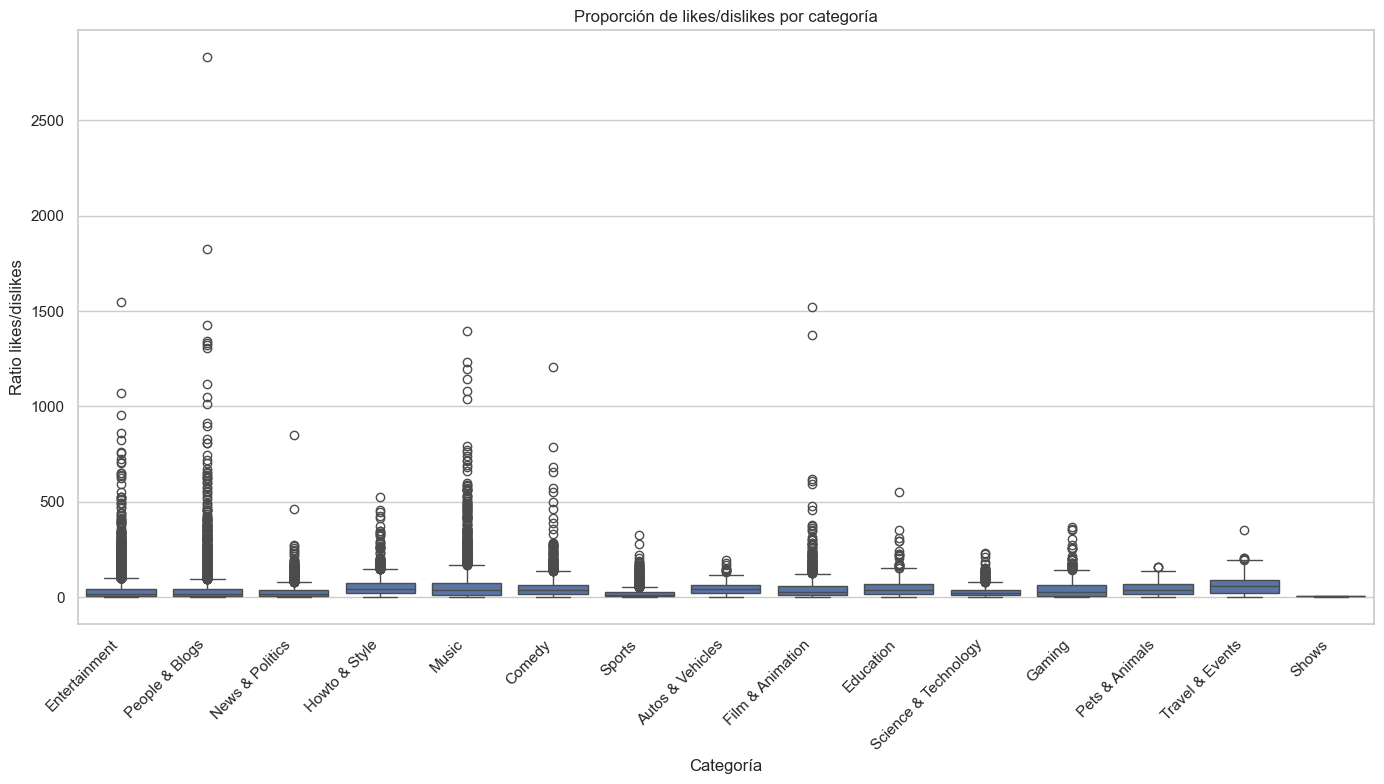

In [9]:
# Proporción de likes/dislikes por categoría
df['like_dislike_ratio'] = df['likes'] / (df['dislikes'] + 1)  # Evitar división por cero

# Crear el boxplot con nombres de categorías
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='category_name', y='like_dislike_ratio')
plt.title('Proporción de likes/dislikes por categoría')
plt.xlabel('Categoría')
plt.ylabel('Ratio likes/dislikes')
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas para mejor legibilidad
plt.tight_layout()
plt.show()

/tmp/ipython-input-18-554840069.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['trending_date'] = pd.to_datetime(df['trending_date'], errors='coerce')


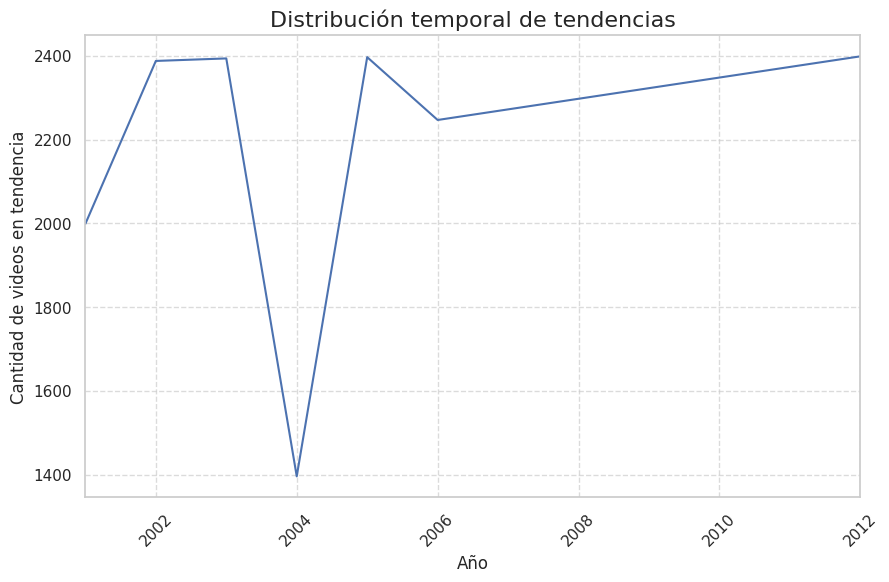

In [18]:
#Distribución temporal de tendencias
df['trending_date'] = pd.to_datetime(df['trending_date'], errors='coerce')
df['year'] = df['trending_date'].dt.to_period('Y')
monthly_trends = df.groupby('year').size()
plt.figure(figsize=(10, 6))
monthly_trends.plot(kind='line', linestyle='-', color='b')
plt.title('Distribución temporal de tendencias', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Cantidad de videos en tendencia', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Mostrar información antes de la limpieza
print("Información antes de la limpieza:")
print("Número de filas:", df.shape[0])
print("Número de columnas:", df.shape[1])
print("Valores nulos:\n", df.isnull().sum())
print("Número de duplicados:", df.duplicated().sum())

Información antes de la limpieza:
Número de filas: 44043
Número de columnas: 22
Valores nulos:
 video_id                     84
trending_date             28823
title                      3533
channel_title              3542
category_id                3592
publish_time               3592
tags                       3563
views                      3592
likes                      3592
dislikes                   3592
comment_count              3592
thumbnail_link             3572
comments_disabled          3592
ratings_disabled           3592
video_error_or_removed     3592
description                7797
state                         0
lat                           0
lon                           0
geometry                      0
like_dislike_ratio         3592
year                      28823
dtype: int64
Número de duplicados: 1318


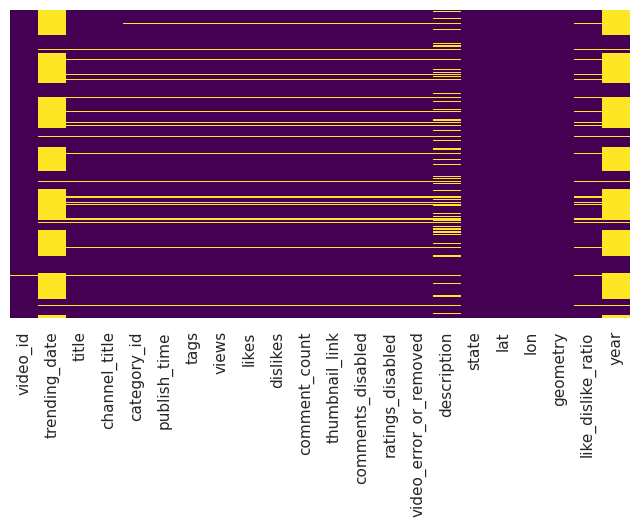

In [ ]:
plt.figure(figsize=(8, 4))
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')
plt.show()

In [ ]:
# Contar cuántas filas tienen nulos en 'publish_time' Y 'views'
# para verifica si esos valores nulos (3592) son los mismos registros
print("\nNúmero de filas con nulos en 'publish_time' y 'views':",
      df['publish_time'].isnull().sum() == df['views'].isnull().sum())


Número de filas con nulos en 'publish_time' y 'views': True


In [ ]:
# Contar cuántos video_id están duplicados
# (es decir, aparecen más de una vez en la columna)
print("\nNúmero de IDs de video duplicados (video_id que aparecen más de una vez):",
      df['video_id'].duplicated().sum())

# Mostrar los video_id que están duplicados y cuántas veces aparecen
duplicated_video_ids = df[df['video_id'].duplicated(keep=False)]['video_id'].value_counts()
if not duplicated_video_ids.empty:
    print("\nVideo_IDs duplicados y sus recuentos:")
    print(duplicated_video_ids.head()) # Muestra los primeros 5 duplicados más frecuentes
    print(f"Total de video_ids únicos con duplicados: {len(duplicated_video_ids)}")
else:
    print("\nNo hay video_id que aparezcan más de una vez.")


Número de IDs de video duplicados (video_id que aparecen más de una vez): 9792

Video_IDs duplicados y sus recuentos:
video_id
\n                                                                                                                              794
#NAME?                                                                                                                          516
                                                                                                                                140
\n█║▌│█│║▌║││█║▌│║▌║                                                                                                             40
\n Carmen8a recetas saludables  https://www.facebook.com/Carmen8a-Recetas-Saludables-batidos-y-mas-1466971086875314/?fref=ts     38
Name: count, dtype: int64
Total de video_ids únicos con duplicados: 5843


In [ ]:
print("\nEstadísticas descriptivas para columnas numéricas:")
print(df[['views', 'likes', 'dislikes', 'comment_count']].describe())


Estadísticas descriptivas para columnas numéricas:
              views         likes      dislikes  comment_count
count  4.045100e+04  4.045100e+04  4.045100e+04   40451.000000
mean   3.423820e+05  1.586184e+04  7.471604e+02    2039.660008
std    1.714691e+06  8.108987e+04  1.095358e+04   13938.031797
min    1.570000e+02  0.000000e+00  0.000000e+00       0.000000
25%    1.681300e+04  2.990000e+02  1.700000e+01      42.000000
50%    5.697300e+04  1.246000e+03  6.300000e+01     196.000000
75%    2.068940e+05  7.226000e+03  2.670000e+02     885.000000
max    1.009124e+08  4.470923e+06  1.353667e+06  905925.000000


In [ ]:
print("\nFilas con 'likes' negativos (si los hay):")
print(df[df['likes'] < 0])

# Un view de 0 puede ser válido para un video recién subido.
print("\nFilas con 'views' <= 0 (si los hay):")
print(df[df['views'] <= 0].head()) # Muestra solo las primeras 5


Filas con 'likes' negativos (si los hay):
Empty DataFrame
Columns: [video_id, trending_date, title, channel_title, category_id, publish_time, tags, views, likes, dislikes, comment_count, thumbnail_link, comments_disabled, ratings_disabled, video_error_or_removed, description, state, lat, lon, geometry, like_dislike_ratio, year]
Index: []

[0 rows x 22 columns]

Filas con 'views' <= 0 (si los hay):
Empty DataFrame
Columns: [video_id, trending_date, title, channel_title, category_id, publish_time, tags, views, likes, dislikes, comment_count, thumbnail_link, comments_disabled, ratings_disabled, video_error_or_removed, description, state, lat, lon, geometry, like_dislike_ratio, year]
Index: []

[0 rows x 22 columns]


In [ ]:
# Longitud de video_id (ej: para IDs de YouTube, suelen tener 11 caracteres)
# Ignoramos los nulos
if 'video_id' in df.columns:
    df_clean_video_id = df.dropna(subset=['video_id'])
    print(f"\nLongitudes de 'video_id': {df_clean_video_id['video_id'].str.len().value_counts()}")


Longitudes de 'video_id': video_id
11     39960
2        828
6        517
1        141
42        99
       ...  
177        1
197        1
80         1
224        1
203        1
Name: count, Length: 124, dtype: int64


In [ ]:
if 'video_id' in df.columns:
    df_clean_video_id = df.dropna(subset=['video_id'])
    video_id_lengths = df_clean_video_id['video_id'].str.len().value_counts()

    # buscar por longitud deseada
    desired_lengths = [11, 6, 42, 224, 203]
    filtered_lengths = video_id_lengths[video_id_lengths.index.isin(desired_lengths)]

    print(f"\nLongitudes de 'video_id' (sin nulos) para longitudes específicas: {filtered_lengths}")
    print("\nEjemplos de video_id por longitud:")
    for length in desired_lengths:
        if length in filtered_lengths.index:
            count = filtered_lengths[length]
            print(f"Longitud {length} (Conteo: {count}):")
            # Mostrar los primeros 5 video_id de esta longitud
            print(df_clean_video_id[df_clean_video_id['video_id'].str.len() == length]['video_id'].head().tolist())


Longitudes de 'video_id' (sin nulos) para longitudes específicas: video_id
11     39960
6        517
42        99
224        1
203        1
Name: count, dtype: int64

Ejemplos de video_id por longitud:
Longitud 11 (Conteo: 39960):
['SbOwzAl9ZfQ', 'klOV6Xh-DnI', '6L2ZF7Qzsbk', 'hcY52MFWMDM', '_OXDcGPVAa4']
Longitud 6 (Conteo: 517):
['#NAME?', '#NAME?', '#NAME?', '#NAME?', '#NAME?']
Longitud 42 (Conteo: 99):
['\\nTwitter: https://twitter.com/LaRutaVerde', '\\n3 tazas de malvaviscos blancos (200 gr) ', '\\nhttps://www.facebook.com/DeborahLivasPag', '\\nhttps://plus.google.com/u/o/DeborahLivas', '\\nhttps://www.twitter.com/ArmandoLivasPag"']
Longitud 224 (Conteo: 1):
['Más vídeos de Internacional: http://cort.as/YGDjMás vídeos de EL PAÍS: http://cort.as/YGC9Síguenos en Facebook: https://www.facebook.com/elpaisTwitter: https://twitter.com/el_paisInstagram: https://www.instagram.com/el_pais"']
Longitud 203 (Conteo: 1):
['El propósito de El Salvador 4K es hacerte recordar la vida sencilla(pe

In [ ]:
# Realizar la limpieza

# Eliminar duplicados
df = df.drop_duplicates()

# Reemplazar valores nulos en 'description' con Sin descripción
df.loc[:, 'description'] = df['description'].fillna("Sin descripción")

# Convertir 'category_id' a string para coincidir con el JSON y unir las categorías
df['category_id'] = df['category_id'].astype(str).str.replace('.0', '', regex=False)
categories_df['category_id'] = categories_df['category_id'].astype(str)
df = df.merge(categories_df, left_on='category_id', right_on='category_id', how='left', suffixes=('', '_y'))

# Eliminar columna redundante tras el merge
if 'category_name_y' in df.columns:
    df = df.drop('category_name_y', axis=1)
if 'category_name' in df.columns and 'category_name_x' in df.columns:
    df = df.drop('category_name_x', axis=1)

# Conversión de columnas de fecha, si existen
date_cols = ['publish_time', 'trending_date']
for col in date_cols:
    if col in df.columns:
        # Correcting the date format for 'publish_time'
        if col == 'publish_time':
            df[col] = pd.to_datetime(df[col], format='%d/%m/%Y %H:%M', errors='coerce')
        else:
            df[col] = pd.to_datetime(df[col], errors='coerce')


# Crear columna 'year' a partir de 'trending_date' si existe
def add_year_column(df):
    if 'trending_date' in df.columns:
        df['year'] = df['trending_date'].dt.to_period('Y')
    return df
df = add_year_column(df)

# Tratar nulos en 'state' si existe
def fill_state_nulls(df):
    if 'state' in df.columns:
        df['state'] = df['state'].fillna('Desconocido')
    return df
df = fill_state_nulls(df)

# --- FILTRADO FINAL DE NULOS EN COLUMNAS CLAVE ---
# Asegurarse de que trending_date, year y category_name no tengan nulos
target_analysis_cols = ['title', 'channel_title', 'category_id', 'publish_time', 'views', 'likes', 'dislikes', 'comment_count', 'trending_date', 'year', 'category_name']
cols_to_check = [col for col in target_analysis_cols if col in df.columns]
df_cleaned = df.dropna(subset=cols_to_check)

# Define numeric_columns after df_cleaned is created
numeric_columns = df_cleaned.select_dtypes(include=['float64', 'int64']).columns


# Visualización de outliers con boxplots antes de eliminarlos
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

df_cleaned = remove_outliers(df_cleaned, numeric_columns)

# Crear columnas de ratios después de la limpieza
df_cleaned['like_dislike_ratio'] = df_cleaned['likes'] / (df_cleaned['dislikes'] + 1)
df_cleaned['views_comments_ratio'] = df_cleaned['views'] / (df_cleaned['comment_count'] + 1)

# Mostrar información después de la limpieza completa
print("\nInformación después de la limpieza completa:")
print("Número de filas:", df_cleaned.shape[0])
print("Número de columnas:", df_cleaned.shape[1])
print("Valores nulos:\n", df_cleaned.isnull().sum())

# Eliminar filas con nulos en columnas clave después de la limpieza y outliers
df_cleaned = df_cleaned.dropna(subset=['trending_date', 'year', 'category_name'])


Información después de la limpieza completa:
Número de filas: 46
Número de columnas: 24
Valores nulos:
 video_id                  0
trending_date             0
title                     0
channel_title             0
category_id               0
publish_time              0
tags                      0
views                     0
likes                     0
dislikes                  0
comment_count             0
thumbnail_link            0
comments_disabled         0
ratings_disabled          0
video_error_or_removed    0
description               0
state                     0
lat                       0
lon                       0
geometry                  0
category_name             0
year                      0
like_dislike_ratio        0
views_comments_ratio      0
dtype: int64


/tmp/ipython-input-13-1154091699.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category_id'] = df['category_id'].astype(str).str.replace('.0', '', regex=False)
/tmp/ipython-input-13-1154091699.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


Visualizando outliers:


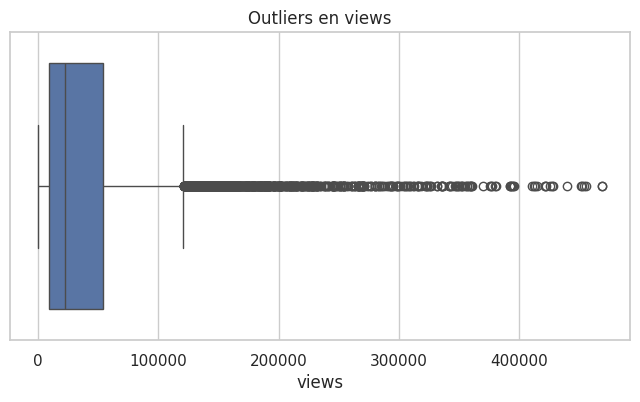

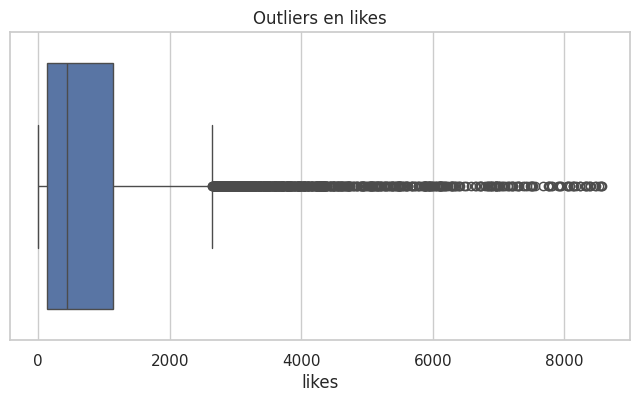

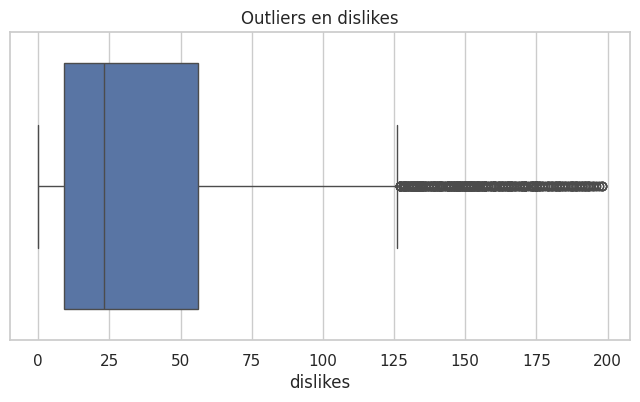

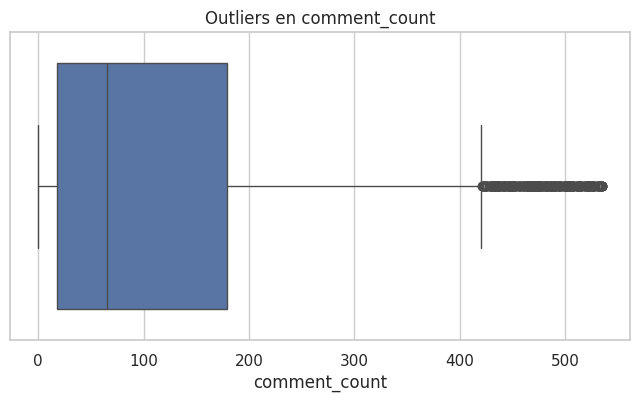

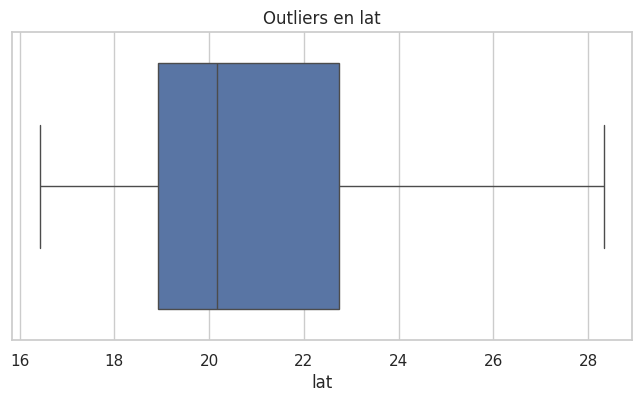

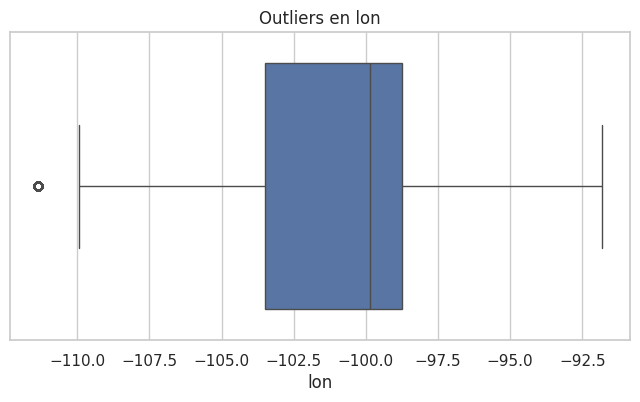

In [ ]:
print("Visualizando outliers:")
for column in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df_cleaned[column])
    plt.title(f'Outliers en {column}')
    plt.show()
    print("\n")

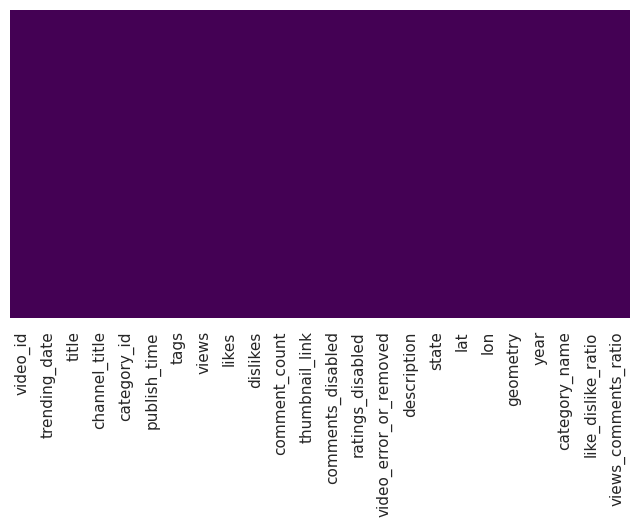

In [ ]:
plt.figure(figsize=(8, 4))
sns.heatmap(df_cleaned.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')
plt.show()

In [ ]:
# Función para eliminar outliers usando el método IQR
def remove_outliers(df_, columns):
    for column in columns:
        Q1 = df_[column].quantile(0.25)
        Q3 = df_[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_ = df_[(df_[column] >= lower_bound) & (df_[column] <= upper_bound)]
    return df_

# Eliminar outliers
df_clean_sin_outliers = remove_outliers(df_cleaned, numeric_columns)

Visualizando sin outliers:


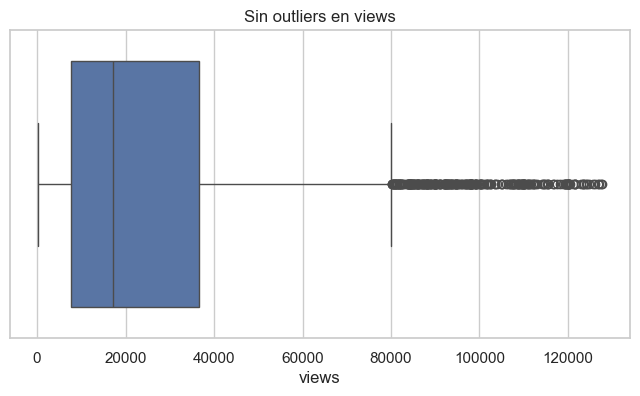

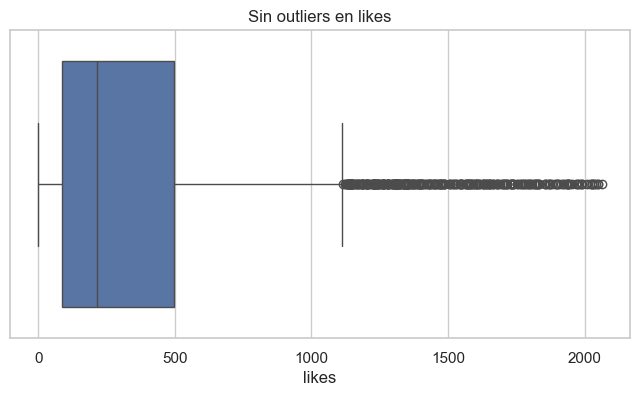

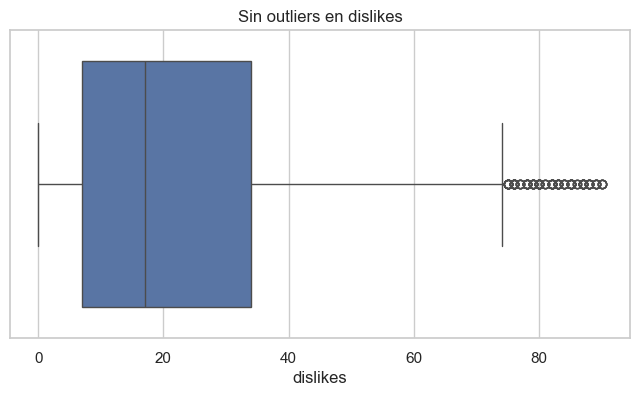

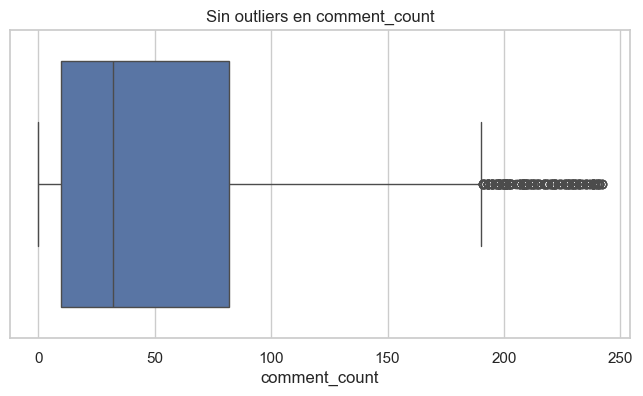

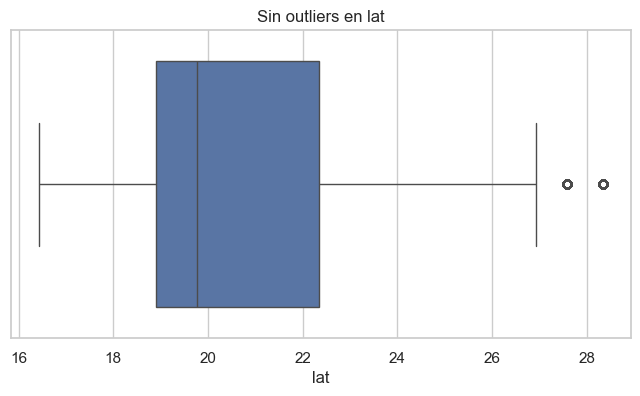

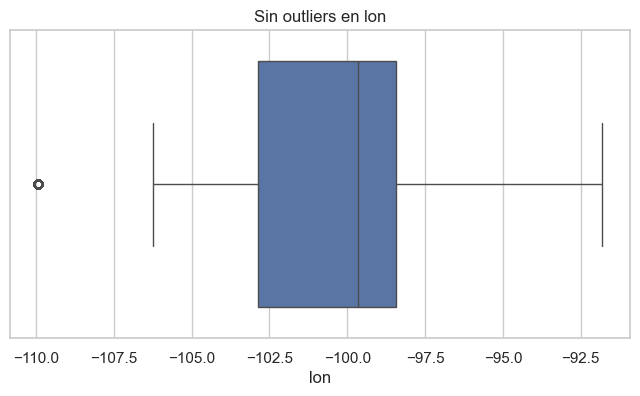

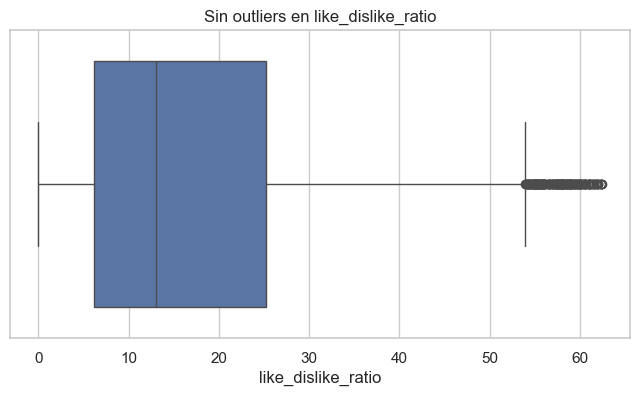

In [ ]:
print("Visualizando sin outliers:")
for column in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df_clean_sin_outliers[column])
    plt.title(f'Sin outliers en {column}')
    plt.show()
    print("\n")

In [ ]:
# Mostrar información después de eliminar outliers
print("\nInformación del dataset después de eliminar outliers:")
print("Número de filas:", df_clean_sin_outliers.shape[0])
print("Número de columnas:", df_clean_sin_outliers.shape[1])
print("Valores nulos por columna:\n", df_clean_sin_outliers.isnull().sum())


Información del dataset después de eliminar outliers:
Número de filas: 5149
Número de columnas: 24
Valores nulos por columna:
 video_id                  0
trending_date             0
title                     0
channel_title             0
category_id               0
publish_time              0
tags                      0
views                     0
likes                     0
dislikes                  0
comment_count             0
thumbnail_link            0
comments_disabled         0
ratings_disabled          0
video_error_or_removed    0
description               0
state                     0
lat                       0
lon                       0
geometry                  0
like_dislike_ratio        0
year                      0
category_name             0
views_comments_ratio      0
dtype: int64


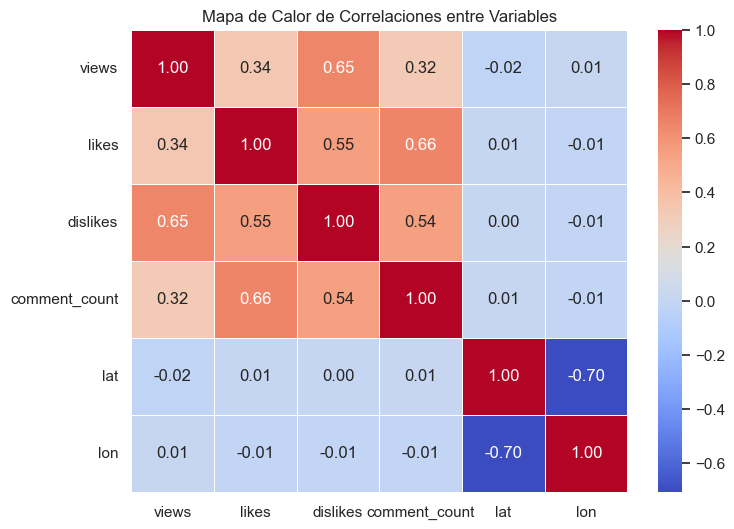

In [ ]:
# Asegúrate de tener tu DataFrame 'df_cleaned' preparado
# Selecciona las columnas relevantes para la correlación
correlation_columns = ['views', 'likes', 'dislikes', 'comment_count', 'lat', 'lon']

# Calcula la matriz de correlación
correlation_matrix = df_cleaned[correlation_columns].corr()

# Configura el tamaño del gráfico
plt.figure(figsize=(8, 6))

# Crea el heatmap con seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Añade título y muestra el gráfico
plt.title("Mapa de Calor de Correlaciones entre Variables")
plt.show()

In [ ]:
# Ratio de Likes/Dislikes
df_cleaned['like_dislike_ratio'] = df_cleaned['likes'] / (df_cleaned['dislikes'] + 1)  # Añadimos 1 para evitar división por cero

# Ratio de Vistas/Comentarios
df_cleaned['views_comments_ratio'] = df_cleaned['views'] / (df_cleaned['comment_count'] + 1)

In [ ]:
df_cleaned.to_csv('Dataset_limpio.csv', index=False)

In [ ]:
#Modelo de Regresión lineal múltiple

# 2. Selección de variables predictoras y objetivo

predictor_columns = ['likes', 'dislikes', 'comment_count', 'like_dislike_ratio', 'views_comments_ratio']
# Usaremos 'likes', 'dislikes' y 'comment_count' para predecir 'views'
X = df_cleaned[predictor_columns]
y = df_cleaned['views']

#Numéricas
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 3. División de datos en entrenamiento y prueba
# Dividir los datos en un 80% para entrenamiento y 20% para prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Entrenamiento del modelo de regresión lineal múltiple
# Crear una instancia del modelo y entrenarlo con los datos de entrenamiento
model = LinearRegression()
model.fit(X_train, y_train)

# 5. Evaluación del Modelo
# Predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular el error cuadrático medio (MSE), el error absoluto medio (MAE)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

In [ ]:
print("Resultados de la evaluación del modelo:")
print(f"Error absoluto medio (MAE): {mae}")
print(f"Error cuadrático medio (MSE): {mse}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse}")

Resultados de la evaluación del modelo:
Error absoluto medio (MAE): 24569.147770327498
Error cuadrático medio (MSE): 1742201796.4413702
Raíz del error cuadrático medio (RMSE): 41739.69090016564


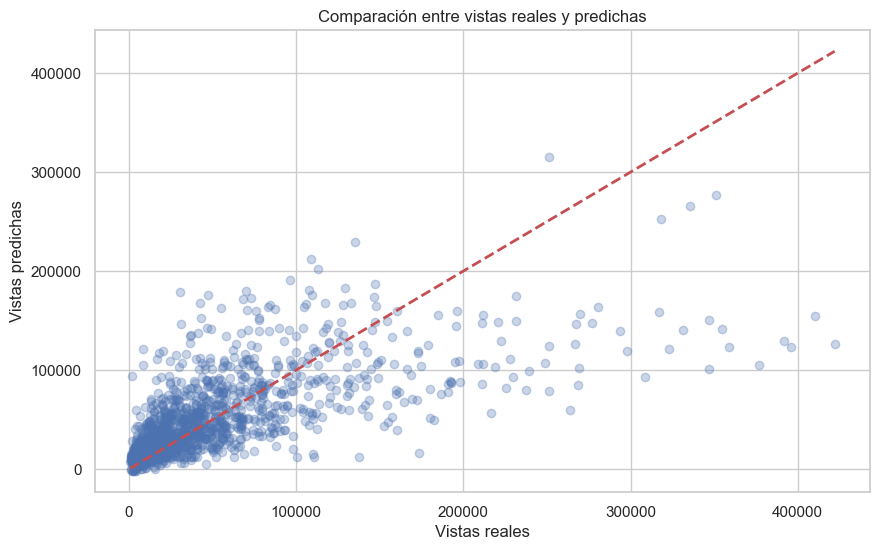

In [ ]:
# Visualización de las predicciones frente a los valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Vistas reales')
plt.ylabel('Vistas predichas')

plt.title('Comparación entre vistas reales y predichas')
plt.show()

In [ ]:
# Análisis de coeficientes del modelo
coef_df = pd.DataFrame(model.coef_, predictor_columns, columns=['Coeficiente'])
print("\nCoeficientes de los predictores en el modelo de regresión:")
print(coef_df)


Coeficientes de los predictores en el modelo de regresión:
                       Coeficiente
likes                  2589.524354
dislikes              36414.051496
comment_count           198.461168
like_dislike_ratio    -3590.342258
views_comments_ratio  11008.731318


In [ ]:
#Modelo de Árbol de decisión

# 2. Selección de Variables Predictoras y Variable Objetivo
# Usamos las mismas variables predictoras que antes
predictor_columns = ['likes', 'dislikes', 'comment_count', 'like_dislike_ratio', 'views_comments_ratio']
X = df_cleaned[predictor_columns]
y = df_cleaned['views']

# Escalado de las Variables Predictoras
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. División de Datos en Entrenamiento y Prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 4. Creación y Entrenamiento del Modelo de Árbol de Decisión
# Puedes ajustar el parámetro 'max_depth' para controlar la profundidad del árbol y evitar el sobreajuste
tree_model = DecisionTreeRegressor(max_depth=10, random_state=42)
tree_model.fit(X_train, y_train)

# 5. Evaluación del Modelo
# Predicciones en el conjunto de prueba
y_pred = tree_model.predict(X_test)

# Calcular métricas de error
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

In [ ]:
print("Resultados de la evaluación del Árbol de Decisión de Regresión:")
print(f"Error absoluto medio (MAE): {mae}")
print(f"Error cuadrático medio (MSE): {mse}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse}")

Resultados de la evaluación del Árbol de Decisión de Regresión:
Error absoluto medio (MAE): 7678.318266915172
Error cuadrático medio (MSE): 268264479.28453764
Raíz del error cuadrático medio (RMSE): 16378.781373610725


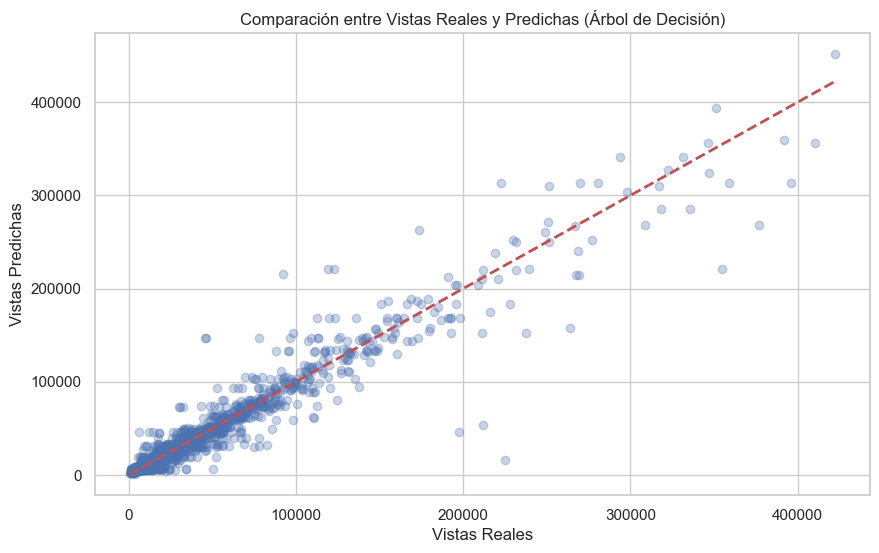

In [ ]:
# Visualización de las Predicciones frente a los Valores Reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Vistas Reales')
plt.ylabel('Vistas Predichas')
plt.title('Comparación entre Vistas Reales y Predichas (Árbol de Decisión)')
plt.show()



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7720\1943360119.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.index, y=feature_importances['Importancia'], palette="viridis")


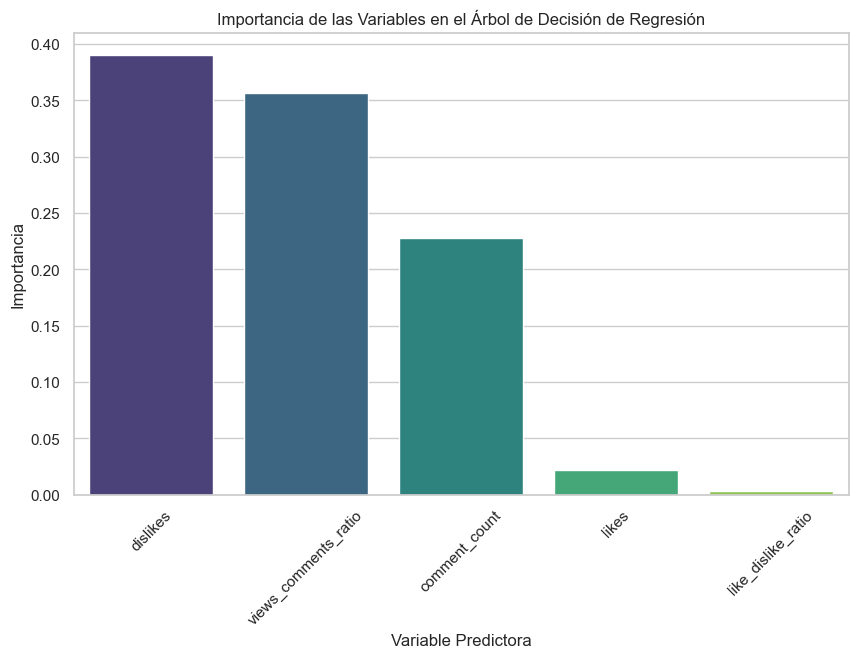

In [ ]:
# Visualización de la Importancia de las Variables
feature_importances = pd.DataFrame(tree_model.feature_importances_, index=predictor_columns, columns=['Importancia'])
feature_importances.sort_values(by='Importancia', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.index, y=feature_importances['Importancia'], palette="viridis")
plt.title("Importancia de las Variables en el Árbol de Decisión de Regresión")
plt.xlabel("Variable Predictora")
plt.ylabel("Importancia")
plt.xticks(rotation=45)
plt.show()

# Respuesta a las preguntas

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7720\2220155809.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=trend_counts.values, y=trend_counts.index, palette="viridis")


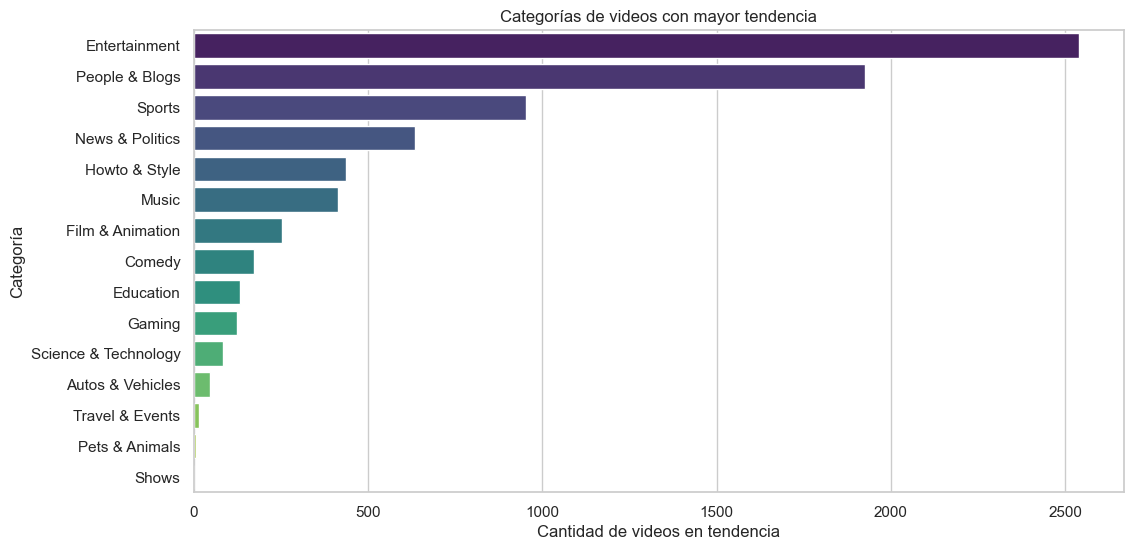

In [ ]:
# Configuración para visualizaciones
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Pregunta 1:
plt.figure(figsize=(12, 6))
trend_counts = df_cleaned['category_name'].value_counts()
sns.barplot(x=trend_counts.values, y=trend_counts.index, palette="viridis")
plt.title("Categorías de videos con mayor tendencia")
plt.xlabel("Cantidad de videos en tendencia")
plt.ylabel("Categoría")
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7720\3290368409.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=likes_by_category, y=likes_by_category.index, palette="coolwarm")


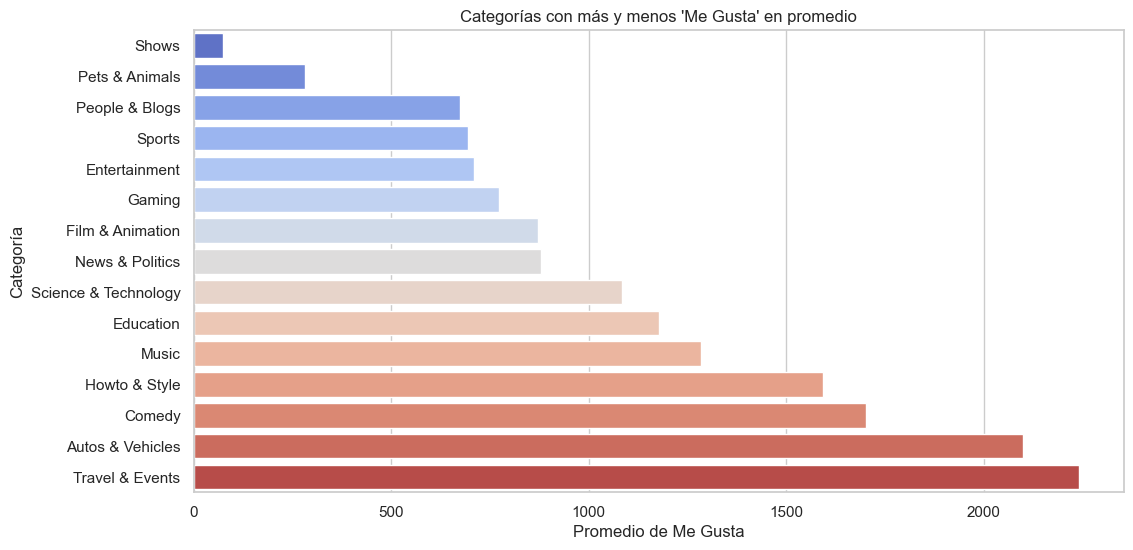

In [ ]:
# Pregunta 2:
plt.figure(figsize=(12, 6))
likes_by_category = df_cleaned.groupby('category_name')['likes'].mean().sort_values()
sns.barplot(x=likes_by_category, y=likes_by_category.index, palette="coolwarm")
plt.title("Categorías con más y menos 'Me Gusta' en promedio")
plt.xlabel("Promedio de Me Gusta")
plt.ylabel("Categoría")
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7720\536246437.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ratio_by_category, y=ratio_by_category.index, palette="Spectral")


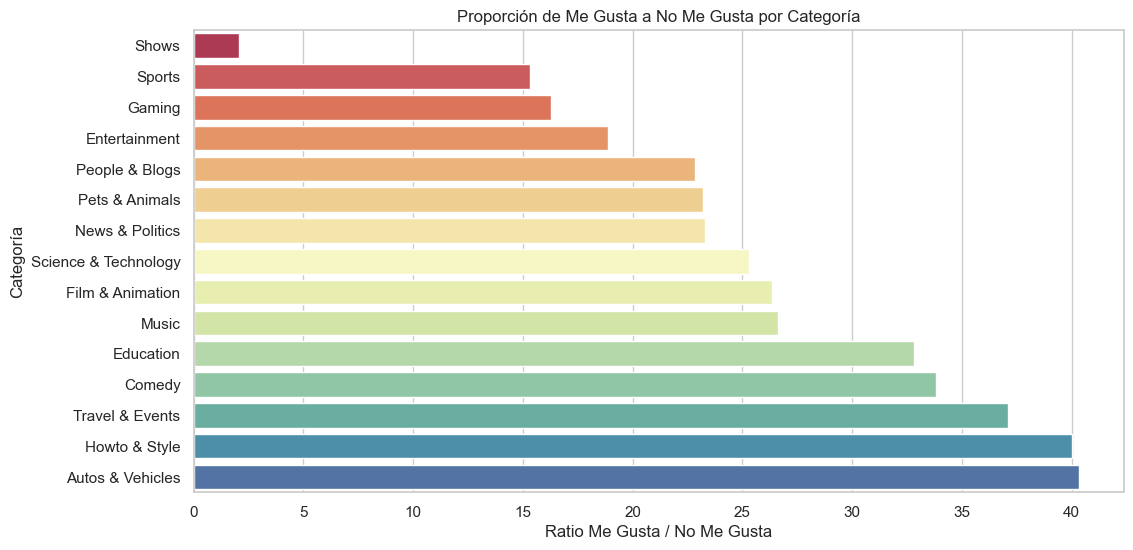

In [ ]:
# Pregunta 3: ¿Qué categorías de videos tienen la mejor proporción (ratio) de 'Me gusta' / 'No me gusta'?
df_cleaned['like_dislike_ratio'] = df_cleaned['likes'] / (df_cleaned['dislikes'] + 1)
ratio_by_category = df_cleaned.groupby('category_name')['like_dislike_ratio'].mean().sort_values()
plt.figure(figsize=(12, 6))
sns.barplot(x=ratio_by_category, y=ratio_by_category.index, palette="Spectral")
plt.title("Proporción de Me Gusta a No Me Gusta por Categoría")
plt.xlabel("Ratio Me Gusta / No Me Gusta")
plt.ylabel("Categoría")
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7720\3188276307.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=views_comments_ratio_by_category, y=views_comments_ratio_by_category.index, palette="magma")


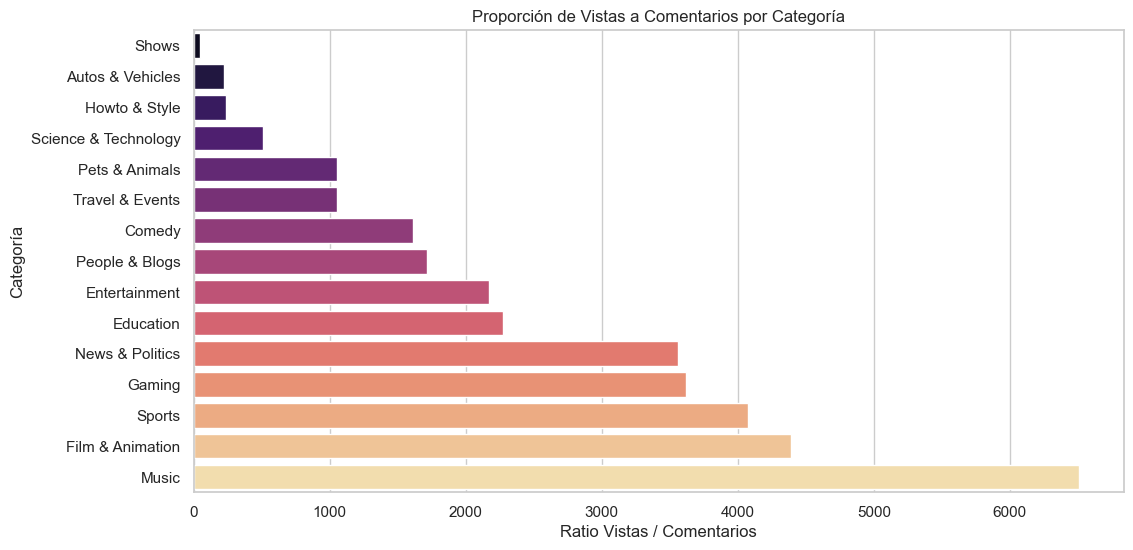

In [ ]:
# Pregunta 4:
df_cleaned['views_comments_ratio'] = df_cleaned['views'] / (df_cleaned['comment_count'] + 1)
views_comments_ratio_by_category = df_cleaned.groupby('category_name')['views_comments_ratio'].mean().sort_values()
plt.figure(figsize=(12, 6))
sns.barplot(x=views_comments_ratio_by_category, y=views_comments_ratio_by_category.index, palette="magma")
plt.title("Proporción de Vistas a Comentarios por Categoría")
plt.xlabel("Ratio Vistas / Comentarios")
plt.ylabel("Categoría")
plt.show()

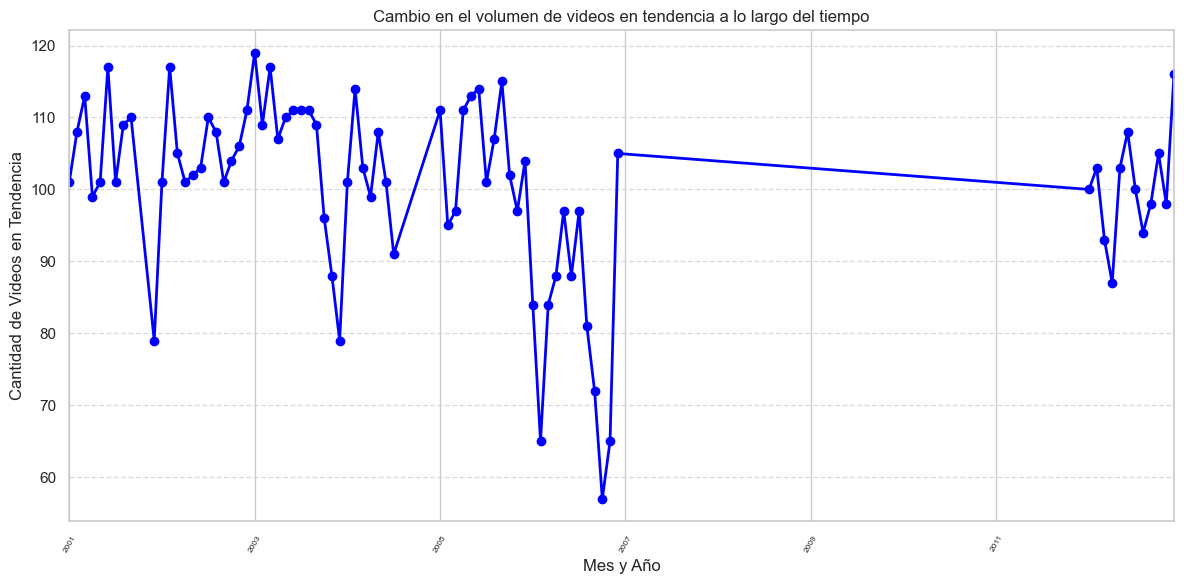

In [ ]:
# Pregunta 5: ¿Cómo ha cambiado el volumen de los videos en tendencia a lo largo del tiempo?
df_cleaned['trending_date'] = pd.to_datetime(df_cleaned['trending_date'], errors='coerce')
df_cleaned['month_year'] = df_cleaned['trending_date'].dt.to_period('M')
trending_volume = df_cleaned['month_year'].value_counts().sort_index()

# Creamos el gráfico de línea
plt.figure(figsize=(12, 6))
trending_volume.plot(kind='line', marker='o', color='blue', linewidth=2)
plt.title("Cambio en el volumen de videos en tendencia a lo largo del tiempo")
plt.xlabel("Mes y Año")
plt.ylabel("Cantidad de Videos en Tendencia")
plt.xticks(rotation=60, fontsize=6)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7720\63421305.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=channel_trend_counts, y=channel_trend_counts.index, palette="cubehelix")


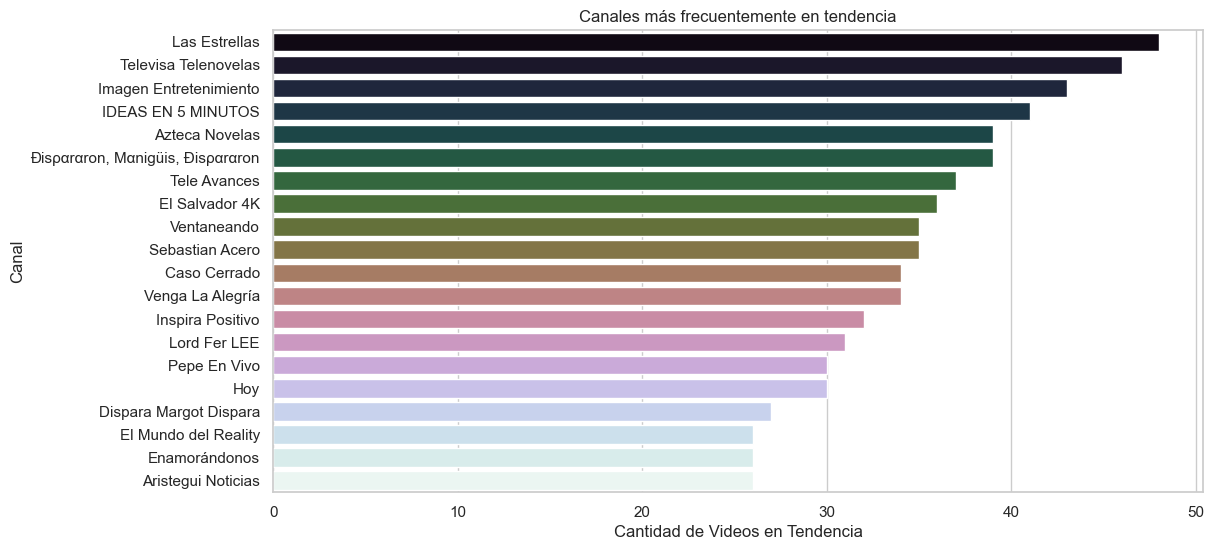

In [ ]:
# Pregunta 6: ¿Qué Canales de YouTube son tendencia más frecuentemente? ¿Y cuáles con menos frecuencia?
channel_trend_counts = df_cleaned['channel_title'].value_counts().head(20)  # Top 20 canales
plt.figure(figsize=(12, 6))
sns.barplot(x=channel_trend_counts, y=channel_trend_counts.index, palette="cubehelix")
plt.title("Canales más frecuentemente en tendencia")
plt.xlabel("Cantidad de Videos en Tendencia")
plt.ylabel("Canal")
plt.show()

Resumen por Estado (Total de Vistas, Me Gusta y No Me Gusta):
                     total_views  total_likes  total_dislikes
state                                                        
Morelos               15332064.0     245151.0         12128.0
Campeche              14174715.0     237881.0         12286.0
Veracruz              14023467.0     250110.0         12106.0
Mexico                13707741.0     255452.0         12890.0
Jalisco               13693749.0     273306.0         12021.0
Oaxaca                13618368.0     224921.0         11776.0
Baja California Sur   13212799.0     253603.0         12729.0
Tabasco               13153477.0     255490.0         11696.0
Tamaulipas            13124830.0     256706.0         12041.0
Queretaro             13039096.0     222701.0         11096.0


<Figure size 1400x800 with 0 Axes>

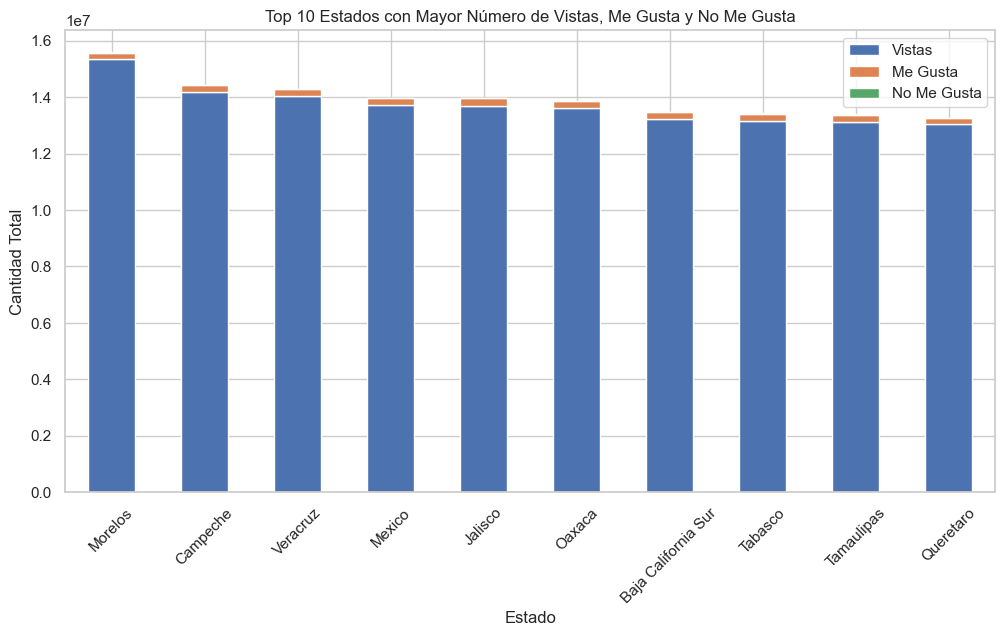

In [ ]:
# Pregunta 7:
# Agrupar por estado y calcular la suma de vistas, me gusta y no me gusta
state_summary = df_cleaned.groupby('state').agg(
     total_views=('views', 'sum'),
    total_likes=('likes', 'sum'),
    total_dislikes=('dislikes', 'sum')
).sort_values(by='total_views', ascending=False)

# Mostrar los resultados del análisis de estados
print("Resumen por Estado (Total de Vistas, Me Gusta y No Me Gusta):")
print(state_summary.head(10))  # Mostrar los 10 estados principales para cada métrica

# Visualización de los estados con el mayor número de "Vistas", "Me gusta" y "No me gusta"
plt.figure(figsize=(14, 8))
state_summary[['total_views', 'total_likes', 'total_dislikes']].head(10).plot(kind='bar', stacked=True)
plt.title("Top 10 Estados con Mayor Número de Vistas, Me Gusta y No Me Gusta")
plt.xlabel("Estado")
plt.ylabel("Cantidad Total")
plt.xticks(rotation=45)
plt.legend(["Vistas", "Me Gusta", "No Me Gusta"])
plt.show()

Promedio de comentarios para videos en tendencia (top 10% de vistas): 191.18709677419355
Promedio de comentarios para videos no en tendencia: 103.31788839477836


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7720\2824704044.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Trending', 'Not Trending'], y=[comments_trending, comments_non_trending], palette="Set2")


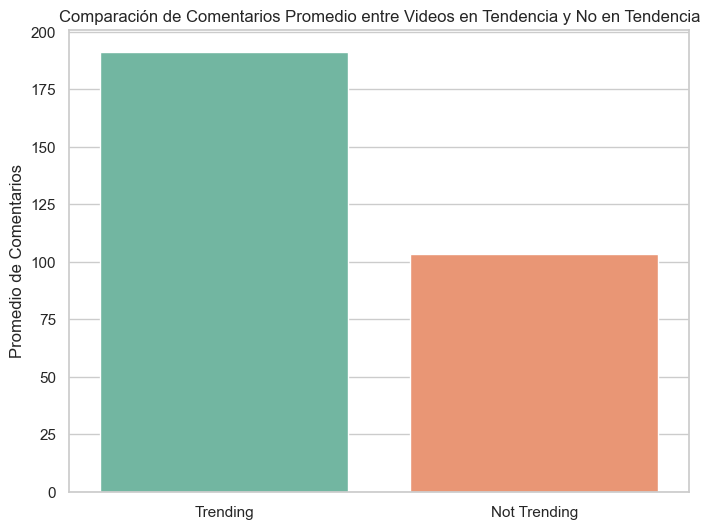

In [ ]:
# Pregunta 8:
# Definir el umbral para considerar un video en "tendencia" (top 10% en vistas)
top_trending_threshold = df_cleaned['views'].quantile(0.9)

# Crear una nueva columna para identificar si un video es "en tendencia" o no
df_cleaned['is_trending'] = df_cleaned['views'] >= top_trending_threshold

# Calcular el promedio de comentarios para videos en tendencia y no en tendencia
comments_trending = df_cleaned[df_cleaned['is_trending']]['comment_count'].mean()
comments_non_trending = df_cleaned[~df_cleaned['is_trending']]['comment_count'].mean()

# Mostrar los resultados
print("Promedio de comentarios para videos en tendencia (top 10% de vistas):", comments_trending)
print("Promedio de comentarios para videos no en tendencia:", comments_non_trending)

# Visualización de los resultados
plt.figure(figsize=(8, 6))
sns.barplot(x=['Trending', 'Not Trending'], y=[comments_trending, comments_non_trending], palette="Set2")
plt.title("Comparación de Comentarios Promedio entre Videos en Tendencia y No en Tendencia")
plt.ylabel("Promedio de Comentarios")
plt.show()



In [ ]:
#Pregunta 9:

#Ejecutar el código final antes
#Modelo de Árbol de decisión

# 2. Selección de Variables Predictoras y Variable Objetivo
# Usamos las mismas variables predictoras que antes
predictor_columns = ['likes', 'dislikes', 'comment_count', 'like_dislike_ratio', 'views_comments_ratio']
X = df_cleaned[predictor_columns]
y = df_cleaned['views']

# Escalado de las Variables Predictoras
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. División de Datos en Entrenamiento y Prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 4. Creación y Entrenamiento del Modelo de Árbol de Decisión
# Puedes ajustar el parámetro 'max_depth' para controlar la profundidad del árbol y evitar el sobreajuste
tree_model = DecisionTreeRegressor(max_depth=10, random_state=42)
tree_model.fit(X_train, y_train)

# 5. Evaluación del Modelo
# Predicciones en el conjunto de prueba
y_pred = tree_model.predict(X_test)

# Calcular métricas de error
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)



In [ ]:
print("Resultados de la evaluación del Árbol de Decisión de Regresión:")
print(f"Error absoluto medio (MAE): {mae}")
print(f"Error cuadrático medio (MSE): {mse}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse}")

Resultados de la evaluación del Árbol de Decisión de Regresión:
Error absoluto medio (MAE): 7678.318266915172
Error cuadrático medio (MSE): 268264479.28453764
Raíz del error cuadrático medio (RMSE): 16378.781373610725


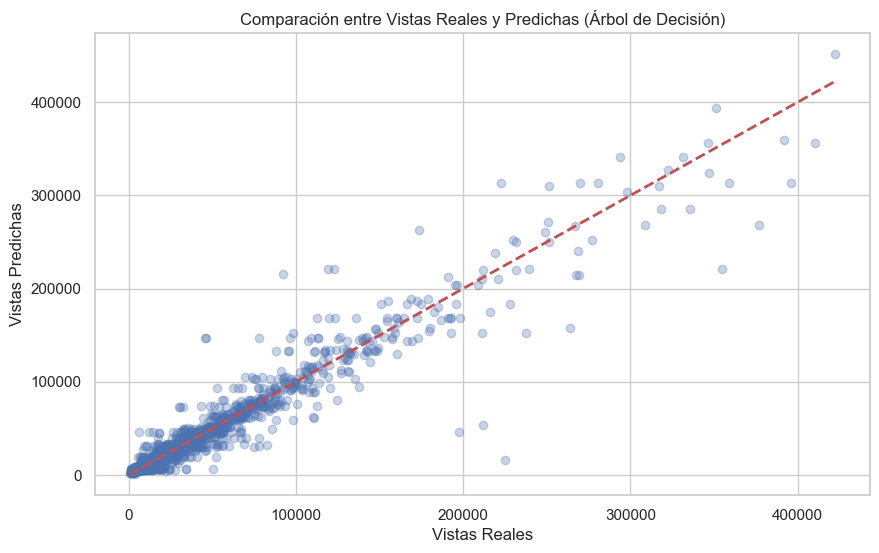

In [ ]:
# Visualización de las Predicciones frente a los Valores Reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Vistas Reales')
plt.ylabel('Vistas Predichas')
plt.title('Comparación entre Vistas Reales y Predichas (Árbol de Decisión)')
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7720\134369477.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.index, y=feature_importances['Importancia'], palette="viridis")


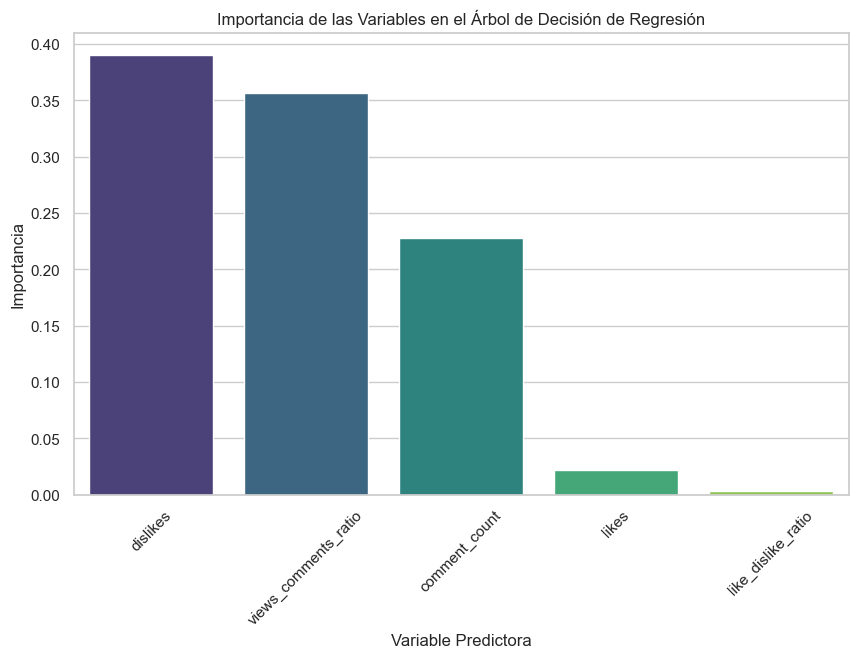

In [ ]:
# Visualización de la Importancia de las Variables
feature_importances = pd.DataFrame(tree_model.feature_importances_, index=predictor_columns, columns=['Importancia'])
feature_importances.sort_values(by='Importancia', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.index, y=feature_importances['Importancia'], palette="viridis")
plt.title("Importancia de las Variables en el Árbol de Decisión de Regresión")
plt.xlabel("Variable Predictora")
plt.ylabel("Importancia")
plt.xticks(rotation=45)
plt.show()

# Sí, es factible predecir el número de vistas, ya que los resultados obtenidos en el modelo de árbol de decisión muestran una
# alta precisión en las predicciones, con un bajo error absoluto medio (MAE) y raíz del error cuadrático medio (RMSE). Esto
# indica que el modelo es capaz de capturar las relaciones entre las variables, como la proporción de vistas a comentarios, los
# "likes" y el número de comentarios, y utilizarlas para predecir el número de vistas de manera efectiva. Además, las métricas
# de error sugieren que el modelo tiene un buen desempeño en la mayoría de los casos y puede adaptarse para predecir otras
# métricas de interacción, como "likes" y "dislikes", si se seleccionan las variables predictoras adecuadas. En conclusión, el
# modelo de árbol de decisión demuestra ser una herramienta útil y precisa para anticipar la cantidad de vistas en función de las
# características de interacción del contenido, lo que resulta prometedor para el análisis de popularidad en plataformas de video.